<a href="https://colab.research.google.com/github/redcoding72/Data-Science/blob/main/Quantium_Task_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Import

In [56]:
# Data analysis and wrangling
import pandas as pd
import numpy as np

# Data visualisation
import seaborn as sns
import matplotlib.pyplot as plt
import missingno

# Dates
import datetime
from matplotlib.dates import DateFormatter

# Text analysis
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist as fdist
import re

# Statistical analysis
from scipy.stats import ttest_ind

# Remove warnings
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


##Import and read data

In [57]:
customerData = pd.read_csv('/content/drive/MyDrive/Quantium/QVI_purchase_behaviour.csv')
transactionData = pd.read_excel('/content/drive/MyDrive/Quantium/QVI_transaction_data.xlsx')

##Transaction Data

In [58]:
transactionData.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,43390,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0
1,43599,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3
2,43605,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9
3,43329,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0
4,43330,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8


In [59]:
transactionData['TXN_ID'].nunique()

263127

In [60]:
transactionData[transactionData.duplicated(['TXN_ID'])].head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
42,43605,55,55073,48887,113,Twisties Chicken270g,1,4.6
377,43475,7,7364,7739,20,Doritos Cheese Supreme 330g,2,11.4
419,43391,12,12301,10982,93,Doritos Corn Chip Southern Chicken 150g,2,7.8
476,43351,16,16427,14546,81,Pringles Original Crisps 134g,1,3.7
511,43315,19,19272,16683,31,Infzns Crn Crnchers Tangy Gcamole 110g,2,7.6


In [61]:
transactionData.loc[transactionData['TXN_ID']==48887, :]

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
41,43605,55,55073,48887,4,Dorito Corn Chp Supreme 380g,1,3.25
42,43605,55,55073,48887,113,Twisties Chicken270g,1,4.60


In [62]:
transactionData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264836 entries, 0 to 264835
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   DATE            264836 non-null  int64  
 1   STORE_NBR       264836 non-null  int64  
 2   LYLTY_CARD_NBR  264836 non-null  int64  
 3   TXN_ID          264836 non-null  int64  
 4   PROD_NBR        264836 non-null  int64  
 5   PROD_NAME       264836 non-null  object 
 6   PROD_QTY        264836 non-null  int64  
 7   TOT_SALES       264836 non-null  float64
dtypes: float64(1), int64(6), object(1)
memory usage: 16.2+ MB


In [63]:
transactionData['DATE'].head()

0    43390
1    43599
2    43605
3    43329
4    43330
Name: DATE, dtype: int64

In [68]:
# Function that converts Excel integer into yyyy-mm-dd format
def xlseriesdate_to_datetime(xlserialdate):
    excel_anchor = datetime.datetime(1900, 1, 1)
    if(xlserialdate < 60):
        delta_in_days = datetime.timedelta(days = (xlserialdate - 1))
    else:
        delta_in_days = datetime.timedelta(days = (xlserialdate - 2))
    converted_date = excel_anchor + delta_in_days
    return converted_date

In [ ]:
# Apply function to Date feature in transactionData dataset

transactionData['DATE'] = transactionData['DATE'].apply(xlseriesdate_to_datetime)
# Check the first 5 rows of the new date feature



In [70]:
transactionData.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0
4,2018-08-18,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8


In [71]:
transactionData['PROD_NAME'].head()

0      Natural Chip        Compny SeaSalt175g
1                    CCs Nacho Cheese    175g
2      Smiths Crinkle Cut  Chips Chicken 170g
3      Smiths Chip Thinly  S/Cream&Onion 175g
4    Kettle Tortilla ChpsHny&Jlpno Chili 150g
Name: PROD_NAME, dtype: object

In [72]:
transactionData['PACK_SIZE'] = transactionData['PROD_NAME'].str.extract("(\d+)")
transactionData['PACK_SIZE'] = pd.to_numeric(transactionData['PACK_SIZE'])
transactionData.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3,175
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9,170
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0,175
4,2018-08-18,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8,150


In [74]:
# Value counts of PROD_QTY

transactionData['PROD_QTY'].value_counts()

2      236039
1       27518
5         450
3         430
4         397
200         2
Name: PROD_QTY, dtype: int64

We have two occurences of 200 in the dataset. This seems odd so let's explore further.

In [75]:
transactionData.loc[transactionData['PROD_QTY'] == 200, :]

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE
69762,2018-08-19,226,226000,226201,4,Dorito Corn Chp Supreme 380g,200,650.0,380
69763,2019-05-20,226,226000,226210,4,Dorito Corn Chp Supreme 380g,200,650.0,380


Both these transactions have been made by the same person at the same store. Let's see all the transactions this person has made by tracking his loyalty card number.

In [76]:
transactionData.loc[transactionData['LYLTY_CARD_NBR'] == 226000, :]

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE
69762,2018-08-19,226,226000,226201,4,Dorito Corn Chp Supreme 380g,200,650.0,380
69763,2019-05-20,226,226000,226210,4,Dorito Corn Chp Supreme 380g,200,650.0,380


This customer is not a retail customer, and is most likely purchasing for commercial purposes. We can safely drop this customer from both 'transactionData' and 'customerData' datasets.



In [77]:
transactionData.drop(transactionData.index[transactionData['LYLTY_CARD_NBR'] == 226000], inplace = True)
customerData.drop(customerData.index[customerData['LYLTY_CARD_NBR'] == 226000], inplace = True)

In [78]:
# Create a new dataframe which contains the total sale for each date
a = pd.pivot_table(transactionData,values='TOT_SALES', index ='DATE',aggfunc='sum')
a.head()


,TOT_SALES
DATE,
2018-07-01,5372.2
2018-07-02,5315.4
2018-07-03,5321.8
2018-07-04,5309.9
2018-07-05,5080.9


In [79]:
b = pd.DataFrame(index=pd.date_range(start ='2018-07-01', end='2019-06-30'))
b['TOT_SALES'] = 0
len(b)

365

In [80]:
c = a + b
c.fillna(0, inplace=True)

In [81]:
c.head()

,TOT_SALES
2018-07-01,5372.2
2018-07-02,5315.4
2018-07-03,5321.8
2018-07-04,5309.9
2018-07-05,5080.9


In [82]:
c.index.name = 'Date'
c.rename(columns = {'TOT_SALES' : 'Total Sales'}, inplace=True)
c.head()

,Total Sales
Date,
2018-07-01,5372.2
2018-07-02,5315.4
2018-07-03,5321.8
2018-07-04,5309.9
2018-07-05,5080.9


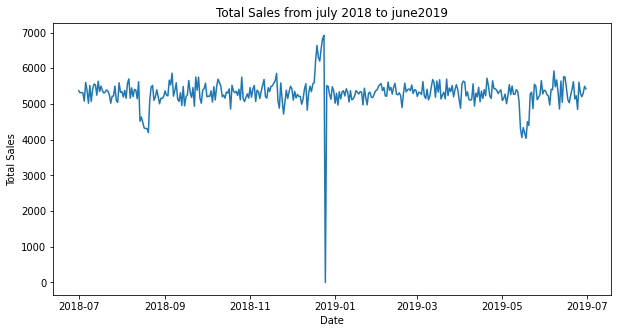

In [83]:
timeline= c.index
graph = c['Total Sales']

fig, ax = plt.subplots(figsize = (10,5))
ax.plot(timeline,graph)

date_form = DateFormatter("%Y-%m")
ax.xaxis.set_major_formatter(date_form)
plt.title('Total Sales from july 2018 to june2019')
plt.xlabel('Date')
plt.ylabel('Total Sales')

plt.show()

We can see that sales spike up during December month, and then zero sale on Christmas Day.

In [84]:
# Confirm zero sale on Christmas Day
c[c['Total Sales'] == 0]

,Total Sales
Date,
2018-12-25,0.0


In [90]:
# Let's look at the December month only
sale_december = c[(c.index < "2019-01-01") & (c.index > "2018-11-30")]

In [86]:
sale_december.head()

,Total Sales
Date,
2018-12-01,5427.6
2018-12-02,5108.2
2018-12-03,5353.3
2018-12-04,5167.3
2018-12-05,5268.0


In [87]:
# Reset index

sale_december.reset_index(drop = True, inplace = True)
sale_december.head()

,Total Sales
0,5427.6
1,5108.2
2,5353.3
3,5167.3
4,5268.0


In [88]:
# Relabel Date
sale_december['Date']=sale_december.index + 1
sale_december.head()

,Total Sales,Date
0,5427.6,1
1,5108.2,2
2,5353.3,3
3,5167.3,4
4,5268.0,5


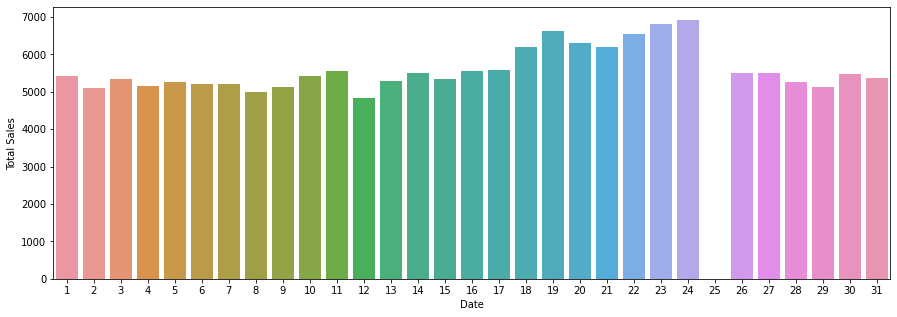

In [89]:
plt.figure(figsize = (15,5))
sns.barplot(x = 'Date', y ='Total Sales', data = sale_december)

In [30]:
# Extract brand name from PROD_NAME and create new column called BRAND

part = transactionData['PROD_NAME'].str.partition()
transactionData['BRAND'] = part[0]
transactionData.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,Natural
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3,175,CCs
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9,170,Smiths
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0,175,Smiths
4,2018-08-18,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8,150,Kettle


In [31]:
transactionData['BRAND'].unique()

array(['Natural', 'CCs', 'Smiths', 'Kettle', 'Old', 'Grain', 'Doritos',
       'Twisties', 'WW', 'Thins', 'Burger', 'NCC', 'Cheezels', 'Infzns',
       'Red', 'Pringles', 'Dorito', 'Infuzions', 'Smith', 'GrnWves',
       'Tyrrells', 'Cobs', 'Woolworths', 'French', 'RRD', 'Tostitos',
       'Cheetos', 'Snbts', 'Sunbites'], dtype=object)

In [ ]:
# Rename brand names for consistency
transactionData['BRAND'].replace('Ncc', 'Natural', inplace = True)
transactionData['BRAND'].replace('Ccs', 'CCS', inplace = True)
transactionData['BRAND'].replace('Smith', 'Smiths', inplace = True)
transactionData['BRAND'].replace(['Grain', 'Grnwves'], 'Grainwaves', inplace = True)
transactionData['BRAND'].replace('Dorito', 'Doritos', inplace = True)
transactionData['BRAND'].replace('Ww', 'Woolworths', inplace = True)
transactionData['BRAND'].replace('Infzns', 'Infuzions', inplace = True)
transactionData['BRAND'].replace(['Red', 'Rrd'], 'Red Rock Deli', inplace = True)
transactionData['BRAND'].replace('Snbts', 'Sunbites', inplace = True)

transactionData['BRAND'].unique()

In [33]:
# Which brand had the top sales?
transactionData.groupby('BRAND').TOT_SALES.sum().sort_values(ascending = False)

BRAND
Kettle           390239.8
Doritos          240590.9
Smiths           224660.2
Pringles         177655.5
Infuzions         99047.6
Old               90785.1
Thins             88852.5
Twisties          81522.1
Tostitos          79789.6
Cobs              70569.8
RRD               64954.5
Tyrrells          51647.4
Grainwaves        43048.8
Cheezels          40029.9
WW                35889.5
Natural           34272.0
Red Rock Deli     30091.5
CCs               18078.9
Cheetos           16884.5
Woolworths        13454.1
Sunbites           9676.4
GrnWves            8568.4
NCC                8046.0
French             7929.0
Burger             6831.0
Name: TOT_SALES, dtype: float64

##Customer Data

In [92]:
customerData.head()

,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,YOUNG SINGLES/COUPLES,Premium
1,1002,YOUNG SINGLES/COUPLES,Mainstream
2,1003,YOUNG FAMILIES,Budget
3,1004,OLDER SINGLES/COUPLES,Mainstream
4,1005,MIDAGE SINGLES/COUPLES,Mainstream


In [93]:
customerData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72636 entries, 0 to 72636
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   LYLTY_CARD_NBR    72636 non-null  int64 
 1   LIFESTAGE         72636 non-null  object
 2   PREMIUM_CUSTOMER  72636 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.2+ MB


In [94]:
# Value counts for lifestages

customerData['LIFESTAGE'].value_counts().sort_values(ascending = False)

RETIREES                  14805
OLDER SINGLES/COUPLES     14609
YOUNG SINGLES/COUPLES     14441
OLDER FAMILIES             9779
YOUNG FAMILIES             9178
MIDAGE SINGLES/COUPLES     7275
NEW FAMILIES               2549
Name: LIFESTAGE, dtype: int64

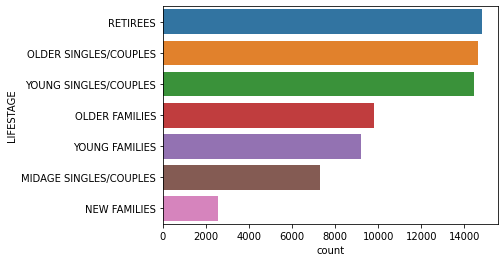

In [95]:
sns.countplot(y = customerData['LIFESTAGE'], order = customerData['LIFESTAGE'].value_counts().index)

In [96]:
# How many unique premium customer categories?

customerData['PREMIUM_CUSTOMER'].nunique()

3

Text(0, 0.5, 'Premium Customer')

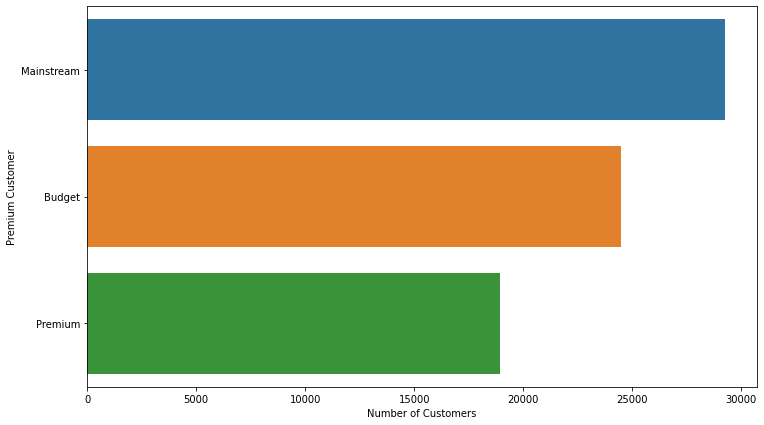

In [97]:
# Value counts for each premium customer category

customerData['PREMIUM_CUSTOMER'].value_counts().sort_values(ascending = False)

plt.figure(figsize = (12, 7))
sns.countplot(y = customerData['PREMIUM_CUSTOMER'], order = customerData['PREMIUM_CUSTOMER'].value_counts().index)
plt.xlabel('Number of Customers')
plt.ylabel('Premium Customer')

In [98]:
# Merge transactionData and customerData together

combineData = pd.merge(transactionData, customerData)

In [99]:
# Check for null values

combineData.isnull().sum()

DATE                0
STORE_NBR           0
LYLTY_CARD_NBR      0
TXN_ID              0
PROD_NBR            0
PROD_NAME           0
PROD_QTY            0
TOT_SALES           0
PACK_SIZE           0
LIFESTAGE           0
PREMIUM_CUSTOMER    0
dtype: int64

##Data analysis on customer segments
Now that our data is ready for analysis, we can define some metrics of interest to the client:

- Who spends the most on chips, describing customers by lifestage and how premium their general purchasing behaviour is
- How many customers are in each segment
- How many chips are bought per customer by segment
- What is the average chip price by customer segment

In [100]:
# Total sales by PREMIUM_CUSTOMER and LIFESTAGE
sales = pd.DataFrame(combineData.groupby(['PREMIUM_CUSTOMER', 'LIFESTAGE']).TOT_SALES.sum())
sales.rename(columns = {'TOT_SALES': 'Total Sales'}, inplace = True)
sales.sort_values(by = 'Total Sales', ascending = False, inplace = True)
sales

Total Sales
PREMIUM_CUSTOMER LIFESTAGE                          
Budget           OLDER FAMILIES            168363.25
Mainstream       YOUNG SINGLES/COUPLES     157621.60
                 RETIREES                  155677.05
Budget           YOUNG FAMILIES            139345.85
                 OLDER SINGLES/COUPLES     136769.80
Mainstream       OLDER SINGLES/COUPLES     133393.80
Premium          OLDER SINGLES/COUPLES     132263.15
Budget           RETIREES                  113147.80
Mainstream       OLDER FAMILIES            103445.55
Premium          RETIREES                   97646.05
Mainstream       YOUNG FAMILIES             92788.75
                 MIDAGE SINGLES/COUPLES     90803.85
Premium          YOUNG FAMILIES             84025.50
                 OLDER FAMILIES             80658.40
Budget           YOUNG SINGLES/COUPLES      61141.60
Premium          MIDAGE SINGLES/COUPLES     58432.65
                 YOUNG SINGLES/COUPLES      41642.10
Budget           MIDAGE SINGLES/COUPLES     35514.80
                 NEW FAMILIES               21928.45
Mainstream       NEW FAMILIES               17013.90
Premium          NEW FAMILIES               11491.10

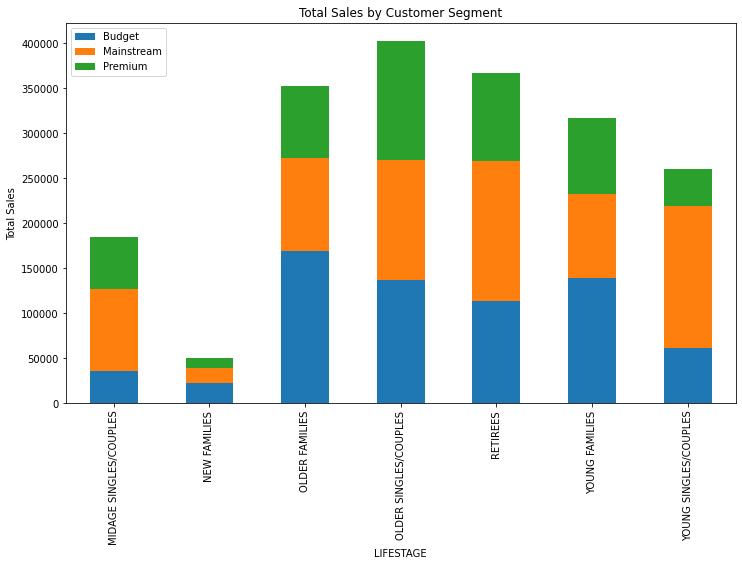

In [101]:
 #Visualise
salesPlot = pd.DataFrame(combineData.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER']).TOT_SALES.sum())
salesPlot.unstack().plot(kind = 'bar', stacked = True, figsize = (12, 7), title = 'Total Sales by Customer Segment')
plt.ylabel('Total Sales')
plt.legend(['Budget', 'Mainstream', 'Premium'], loc = 2)

Top 3 sales come from budget older families, mainstream young singles/couples and mainstream retirees

In [102]:
 #Number of customers by PREMIUM_CUSTOMER and LIFESTAGE

customers = pd.DataFrame(combineData.groupby(['PREMIUM_CUSTOMER', 'LIFESTAGE']).LYLTY_CARD_NBR.nunique())
customers.rename(columns = {'LYLTY_CARD_NBR': 'Number of Customers'}, inplace = True)
customers.sort_values(by = 'Number of Customers', ascending = False).head(10)

Number of Customers
PREMIUM_CUSTOMER LIFESTAGE                                 
Mainstream       YOUNG SINGLES/COUPLES                 8088
                 RETIREES                              6479
                 OLDER SINGLES/COUPLES                 4930
Budget           OLDER SINGLES/COUPLES                 4929
Premium          OLDER SINGLES/COUPLES                 4750
Budget           OLDER FAMILIES                        4675
                 RETIREES                              4454
                 YOUNG FAMILIES                        4017
Premium          RETIREES                              3872
Budget           YOUNG SINGLES/COUPLES                 3779

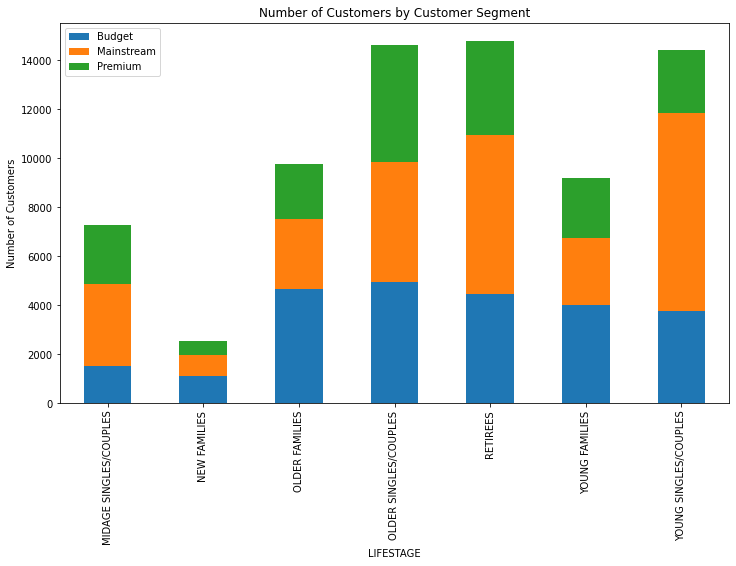

In [103]:
# Visualise

customersPlot = pd.DataFrame(combineData.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER']).LYLTY_CARD_NBR.nunique())
customersPlot.unstack().plot(kind = 'bar', stacked = True, figsize = (12, 7), title = 'Number of Customers by Customer Segment')
plt.ylabel('Number of Customers')
plt.legend(['Budget', 'Mainstream', 'Premium'], loc = 2)

There are more mainstream young singles/couples and retirees. This contributes to to more chips sales in these segments however this is not the major driver for the budget older families segment.

In [104]:
# Average units per customer by PREMIUM_CUSTOMER and LIFESTAGE

avg_units = combineData.groupby(['PREMIUM_CUSTOMER', 'LIFESTAGE']).PROD_QTY.sum() / combineData.groupby(['PREMIUM_CUSTOMER', 'LIFESTAGE']).LYLTY_CARD_NBR.nunique()
avg_units = pd.DataFrame(avg_units, columns = {'Average Unit per Customer'})
avg_units.sort_values(by = 'Average Unit per Customer', ascending = False).head()

,,Average Unit per Customer
PREMIUM_CUSTOMER,LIFESTAGE,
Mainstream,OLDER FAMILIES,9.804309
Budget,OLDER FAMILIES,9.639572
Premium,OLDER FAMILIES,9.578091
Budget,YOUNG FAMILIES,9.238486
Premium,YOUNG FAMILIES,9.209207


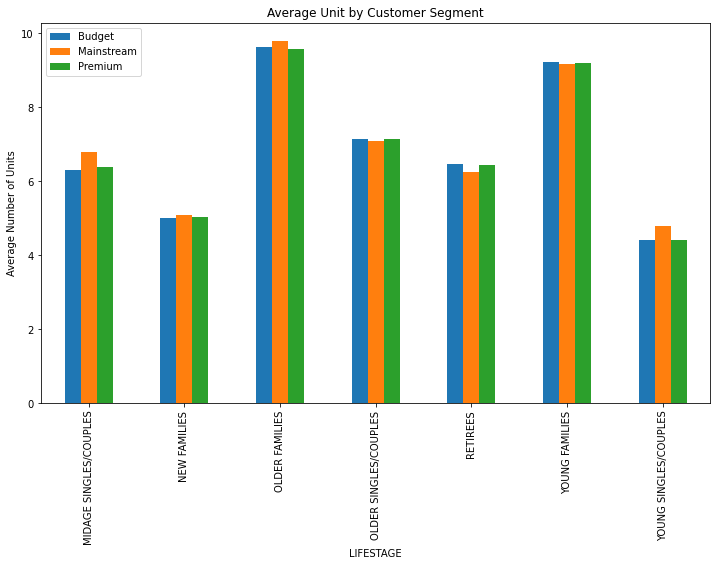

In [105]:
# Visualise 

avgUnitsPlot = pd.DataFrame(combineData.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER']).PROD_QTY.sum() / combineData.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER']).LYLTY_CARD_NBR.nunique())
avgUnitsPlot.unstack().plot(kind = 'bar', figsize = (12, 7), title = 'Average Unit by Customer Segment')
plt.ylabel('Average Number of Units')
plt.legend(['Budget', 'Mainstream', 'Premium'], loc = 2)

Young families and older families buy more chips than other customer categories.

In [106]:
# Average price per unit by PREMIUM_CUSTOMER and LIFESTAGE

avg_price = combineData.groupby(['PREMIUM_CUSTOMER', 'LIFESTAGE']).TOT_SALES.sum() / combineData.groupby(['PREMIUM_CUSTOMER', 'LIFESTAGE']).PROD_QTY.sum()
avg_price = pd.DataFrame(avg_price, columns = {'Price per Unit'})
avg_price.sort_values(by = 'Price per Unit', ascending = False).head()

Price per Unit
PREMIUM_CUSTOMER LIFESTAGE                             
Mainstream       YOUNG SINGLES/COUPLES         4.080079
                 MIDAGE SINGLES/COUPLES        4.000346
                 NEW FAMILIES                  3.939315
Budget           NEW FAMILIES                  3.936178
                 RETIREES                      3.933660

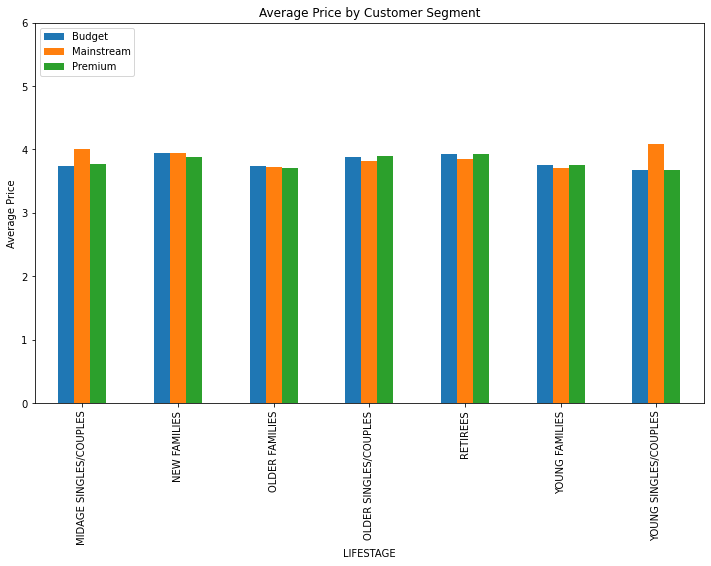

In [107]:
# Visualise 

avgPricePlot = pd.DataFrame(combineData.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER']).TOT_SALES.sum() / combineData.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER']).PROD_QTY.sum())
avgPricePlot.unstack().plot(kind = 'bar', figsize = (12, 7), title = 'Average Price by Customer Segment', ylim = (0, 6))
plt.ylabel('Average Price')
plt.legend(['Budget', 'Mainstream', 'Premium'], loc = 2)

The results revealed that there is a strong difference in the buying behavior of middle-aged and young singles and couples compared to their budget/premium counterparts. Middle-aged and young singles and couples are more willing to buy more crisps compared to their budget and premium counterparts. This may be because high-end shoppers are more likely to buy healthy snacks, and when they buy crisps they consume them rather than for entertainment purposes, or because they don't consider everything just not crisps as a "must have" item when shopping.

In [108]:
# Perform an independent t-test between mainstream vs non-mainstream midage and young singles/couples to test this difference

# Create a new dataframe pricePerUnit
pricePerUnit = combineData

# Create a new column under pricePerUnit called PRICE
pricePerUnit['PRICE'] = pricePerUnit['TOT_SALES'] / pricePerUnit['PROD_QTY']

# Let's have a look
pricePerUnit.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,LIFESTAGE,PREMIUM_CUSTOMER,PRICE
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,YOUNG SINGLES/COUPLES,Premium,3.00
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3,175,MIDAGE SINGLES/COUPLES,Budget,2.10
2,2018-11-10,1,1307,346,96,WW Original Stacked Chips 160g,2,3.8,160,MIDAGE SINGLES/COUPLES,Budget,1.90
3,2019-03-09,1,1307,347,54,CCs Original 175g,1,2.1,175,MIDAGE SINGLES/COUPLES,Budget,2.10
4,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9,170,MIDAGE SINGLES/COUPLES,Budget,1.45


In [109]:
mainstream = pricePerUnit.loc[(pricePerUnit['PREMIUM_CUSTOMER'] == 'Mainstream') & ( (pricePerUnit['LIFESTAGE'] == 'YOUNG SINGLES/COUPLES') | (pricePerUnit['LIFESTAGE'] == 'MIDAGE SINGLES/COUPLES') ), 'PRICE']
nonMainstream = pricePerUnit.loc[(pricePerUnit['PREMIUM_CUSTOMER'] != 'Mainstream') & ( (pricePerUnit['LIFESTAGE'] == 'YOUNG SINGLES/COUPLES') | (pricePerUnit['LIFESTAGE'] == 'MIDAGE SINGLES/COUPLES') ), 'PRICE']


Text(0.5, 0, 'Price per Unit')

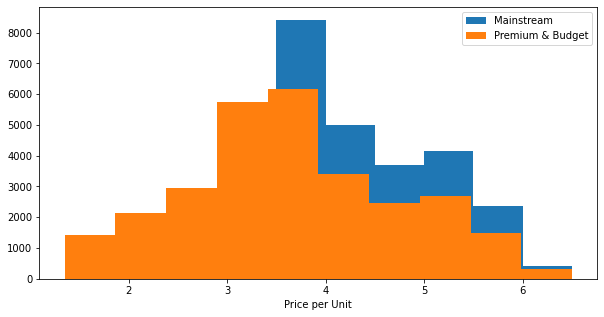

In [110]:
# Compare histograms of mainstream and non-mainstream customers

plt.figure(figsize = (10, 5))
plt.hist(mainstream, label = 'Mainstream')
plt.hist(nonMainstream, label = 'Premium & Budget')
plt.legend()
plt.xlabel('Price per Unit')

In [111]:
print("Mainstream average price per unit: ${:.2f}".format(np.mean(mainstream)))
print("Non-mainstream average price per unit: ${:.2f}".format(np.mean(nonMainstream)))
if np.mean(mainstream) > np.mean(nonMainstream):
    print("Mainstream customers have higher average price per unit. ")
else:
    print("Non-mainstream customers have a higher average price per unit. ")


Mainstream average price per unit: $4.05
Non-mainstream average price per unit: $3.69
Mainstream customers have higher average price per unit. 


##Conclusion
Sales are highest for (Budget, OLDER FAMILIES), (General, YOUNG SINGLES/COUPLES) and (General, RETIRED)
this is mainly due to the fact that there are more customers in these segments
(Mainstream, YOUNG SINGLES/COUPLES) are more likely to pay more per pack of chips than their premium and budget counterparts.